# Market Regime Detection with Clustering Techniques
## This tutorial demonstrates how to use the `ClusteringMarketRegimeAnalyzer` class to detect and analyze market regimes using unsupervised learning techniques.
### 1. Setup and Installation


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import sys
import os

# Import the ClusteringMarketRegimeAnalyzer class
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(project_root)

from patternforge.candlestick.clustering_market_regime import (
    ClusteringMarketRegimeAnalyzer, 
    ClusteringConfig, 
    ClusteringMarketRegime
)

from patternforge.candlestick.visualization import (
    CandlestickVisualizer,
    VisualizationConfig,
    BaseVisualizationSettings
)


# Set up visualization preferences
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_palette("colorblind")

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


### 2. Data Acquisition and Preperation

In [2]:
# Setup visualization environment
def initialize_visualization_environment():
    """Initialize visualization config and settings"""
    # Create default config
    default_config = VisualizationConfig()
    
    # Create custom config with different color scheme
    custom_config = VisualizationConfig(
        color_scheme={
            'bullish': '#00cc00',  # Bright green
            'bearish': '#cc0000',  # Bright red
            'neutral': '#0066cc',  # Blue
            'complex': '#9900cc',  # Purple
            'volume_up': '#00cc00',
            'volume_down': '#cc0000',
            'background': '#ffffff',
            'text': '#000000'
        },
        theme='plotly_white',
        default_height=600,
        default_width=1000,
        pattern_opacity=0.8,
        show_grid=True
    )
    
    # Create base settings
    base_settings = BaseVisualizationSettings(default_config)
    
    return {
        'default_config': default_config,
        'custom_config': custom_config,
        'base_settings': base_settings
    }

# Initialize environment
try:
    viz_env = initialize_visualization_environment()
    print("Visualization environment initialized successfully")
except Exception as e:
    print(f"Error initializing visualization environment: {str(e)}")

Visualization environment initialized successfully


In [3]:
# Data loading functions
import yfinance as yf

def load_stock_data(symbol='AAPL', period='6mo', interval='1d'):
    """Load stock data from Yahoo Finance"""
    ticker = yf.Ticker(symbol)
    df = ticker.history(period=period, interval=interval)
    print(f"Downloaded {len(df)} rows of {symbol} data")
    return df

def load_from_csv(file_path):
    """Load data from a CSV file"""
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"Loaded {len(df)} rows from {file_path}")
    return df

def create_sample_dataset(trend_type='trending', length=200):
    """Create a synthetic dataset with specific characteristics"""
    np.random.seed(42)  # For reproducibility
    
    # Create date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=length)
    dates = pd.date_range(start=start_date, end=end_date, periods=length)
    
    # Base price
    close = np.zeros(length)
    
    if trend_type == 'trending':
        # Create uptrend
        for i in range(length):
            close[i] = 100 + i * 0.5 + np.random.normal(0, 2)
    
    elif trend_type == 'ranging':
        # Create range-bound market
        for i in range(length):
            close[i] = 100 + 10 * np.sin(i/20) + np.random.normal(0, 2)
    
    elif trend_type == 'volatile':
        # Create volatile market
        for i in range(length):
            close[i] = 100 + 5 * np.sin(i/10) + np.random.normal(0, 5)
    
    # Generate OHLC data
    high = close + np.random.uniform(0.5, 3, size=length)
    low = close - np.random.uniform(0.5, 3, size=length)
    open_price = low + np.random.uniform(0, 1, size=length) * (high - low)
    
    # Generate volume
    volume = np.random.uniform(1000, 5000, size=length)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Open': open_price,
        'High': high,
        'Low': low,
        'Close': close,
        'Volume': volume
    }, index=dates)
    
    print(f"Created synthetic {trend_type} dataset with {length} data points")
    return df

# Load sample data
try:
    # For daily data over the course of a year:
    apple_data = load_stock_data('AAPL', '1y')
    msft_data = load_stock_data('MSFT', '1y')
    trending_data = create_sample_dataset('trending')
    ranging_data = create_sample_dataset('ranging')
    volatile_data = create_sample_dataset('volatile')
    
    # # For weekly data over the course of 15 years:
    # apple_data = load_stock_data('AAPL', '15y', "1wk")
    # msft_data = load_stock_data('MSFT', '15y', "1wk")
    # trending_data = create_sample_dataset('trending')
    # ranging_data = create_sample_dataset('ranging')
    # volatile_data = create_sample_dataset('volatile')
    
    df = apple_data.copy()
    
    
    print("Successfully loaded sample datasets")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Downloaded 250 rows of AAPL data
Downloaded 250 rows of MSFT data
Created synthetic trending dataset with 200 data points
Created synthetic ranging dataset with 200 data points
Created synthetic volatile dataset with 200 data points
Successfully loaded sample datasets


Downloaded 250 data points for SPY from 2024-03-19 to 2025-03-18
Creating Plotly candlestick chart...
Creating Matplotlib candlestick chart...


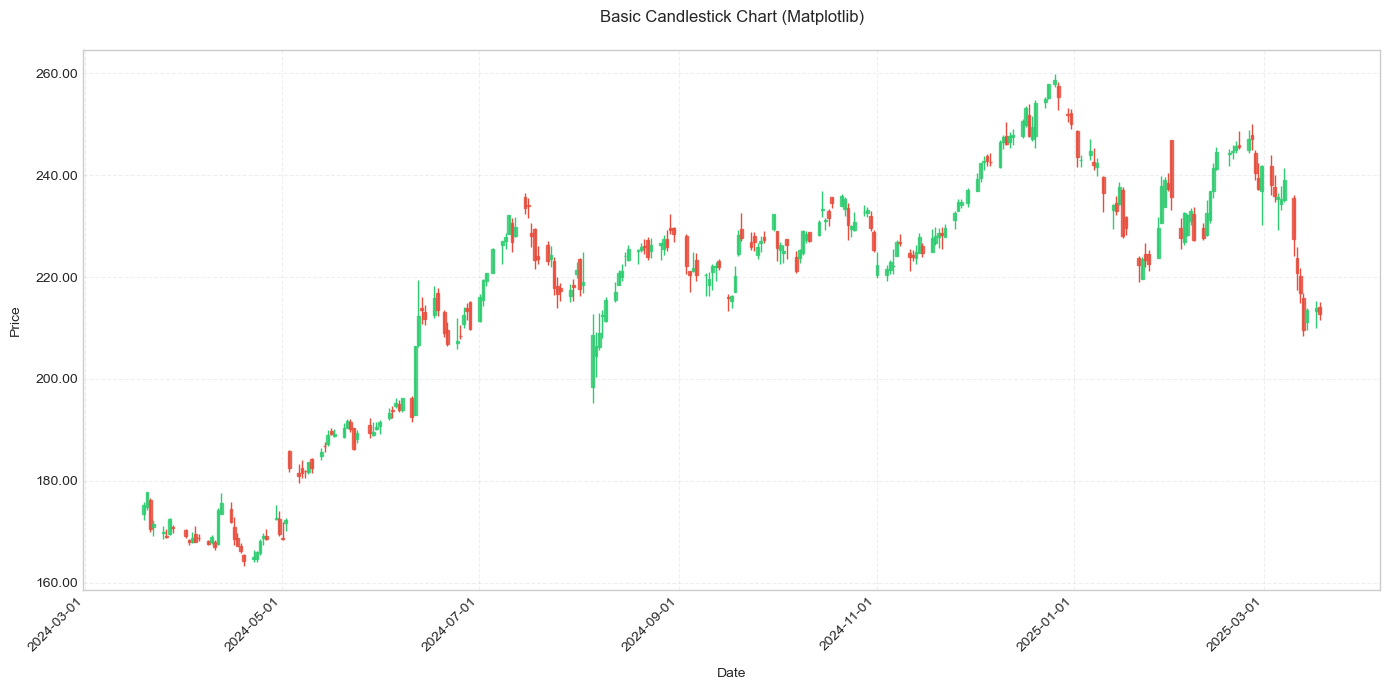

Basic candlestick charts created successfully


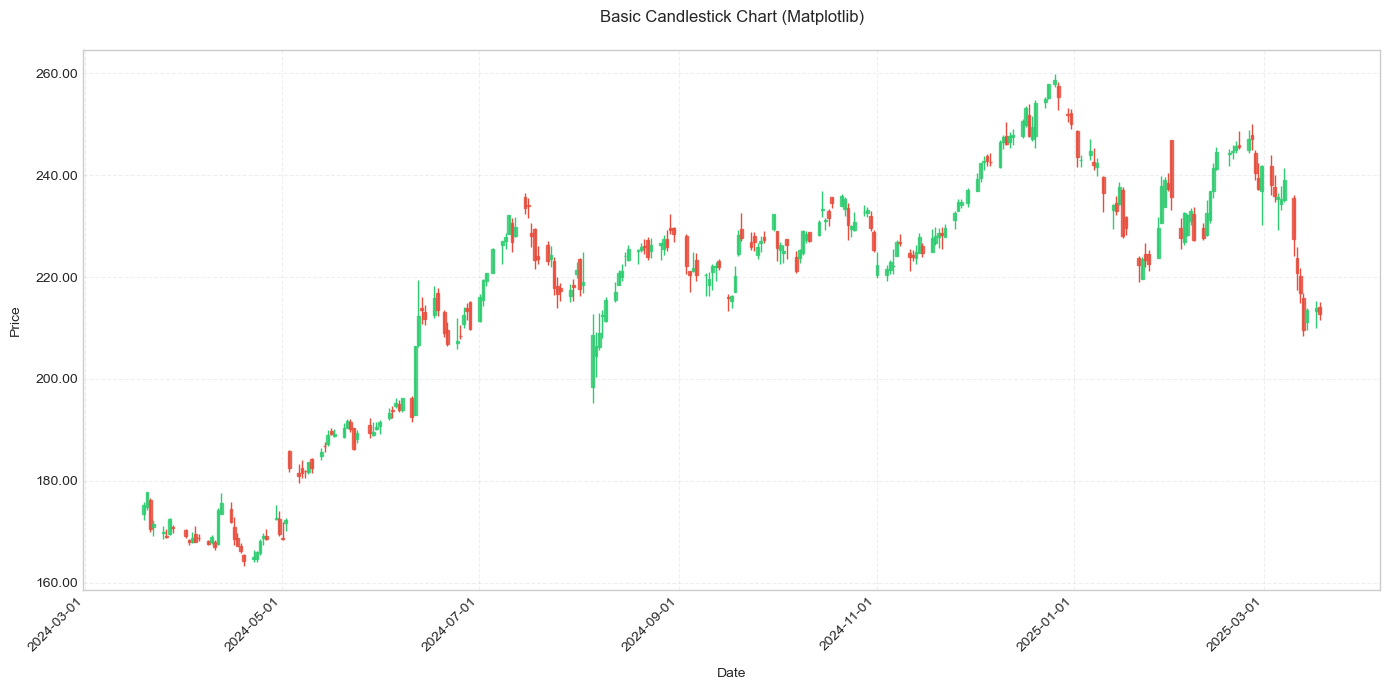

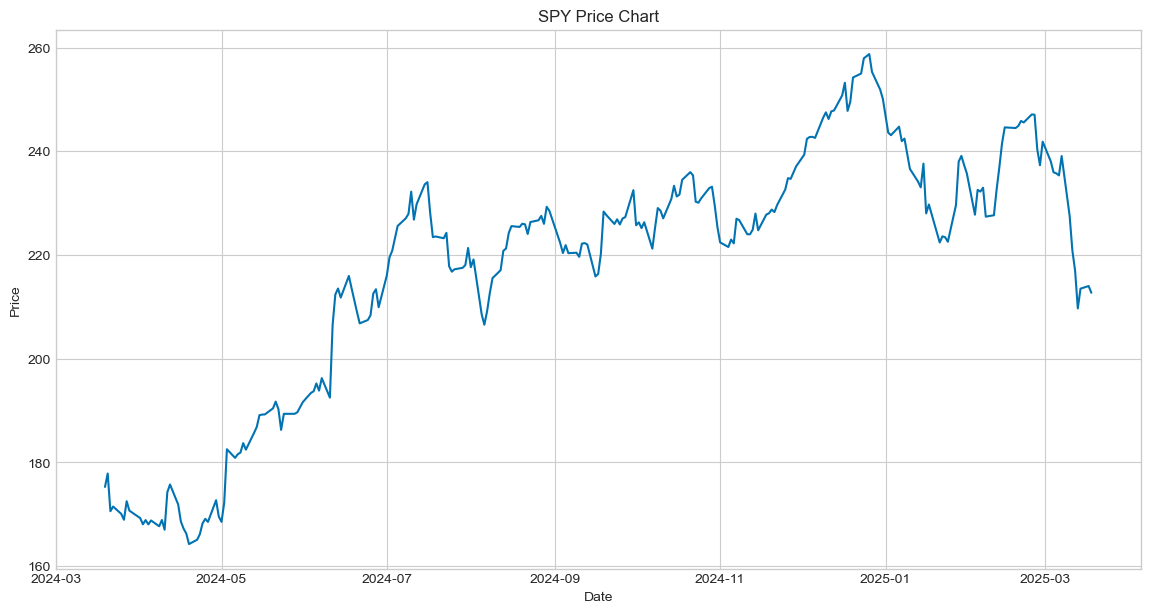

In [10]:
# Display data information
print(f"Downloaded {len(df)} data points for {symbol} from {df.index[0].date()} to {df.index[-1].date()}")
df.head()

# Basic candlestick chart creation
def create_basic_candlestick_charts(data, config):
    """Create basic candlestick charts using both Plotly and Matplotlib"""
    visualizer = CandlestickVisualizer(data, config)
    
    # Plotly implementation
    print("Creating Plotly candlestick chart...")
    plotly_fig = visualizer.create_candlestick_chart(
        use_plotly=True,
        show_volume=True,
        title="Basic Candlestick Chart (Plotly)"
    )
    
    # Matplotlib implementation
    print("Creating Matplotlib candlestick chart...")
    mpl_fig = visualizer.create_candlestick_chart(
        use_plotly=False,
        title="Basic Candlestick Chart (Matplotlib)"
    )
    
    return {
        'visualizer': visualizer,
        'plotly_fig': plotly_fig,
        'mpl_fig': mpl_fig
    }

# Create basic charts
try:
    basic_charts = create_basic_candlestick_charts(
        df, 
        viz_env['default_config']
    )
    
    # Display Plotly chart
    basic_charts['plotly_fig'].show()
    
    # Display Matplotlib chart (for Jupyter notebook)
    from IPython.display import display
    display(basic_charts['mpl_fig'])
    
    print("Basic candlestick charts created successfully")
except Exception as e:
    print(f"Error creating basic charts: {str(e)}")

# Visualize the price data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'])
plt.title(f"{symbol} Price Chart")
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### 3. Configuring the Regime Analyzer


In [4]:
# Create a custom configuration for clustering
config = ClusteringConfig(
    # Feature extraction parameters
    return_periods=[1, 5, 10, 20, 60],
    volatility_periods=[5, 10, 20, 60],
    volume_periods=[5, 10, 20],
    trend_periods=[10, 20, 50, 200],
    autocorr_lags=[1, 5, 10, 20],
    
    # Clustering parameters
    n_clusters=5,  # Number of regimes for k-means and GMM
    cluster_method='gmm',  # Options: 'gmm', 'kmeans', 'dbscan', 'hierarchical', 'hdbscan', 'som'
    
    # Feature processing
    use_pca=True,
    pca_components=10,
    use_robust_scaling=True,
    
    # Custom regime naming (optional)
    regime_names={
        0: 'bullish_trending',
        1: 'bearish_trending',
        2: 'high_volatility',
        3: 'low_volatility_range',
        4: 'transitional'
    }
)

# Initialize the regime analyzer
analyzer = ClusteringMarketRegimeAnalyzer(df, config=config)


In [5]:
# Detect regimes for the full dataset
regimes = analyzer.detect_regimes()

# Display basic information about the detected regimes
print(f"Detected {len(regimes)} distinct regime periods")
for i, regime in enumerate(regimes[:5]):  # Display the first 5 regimes
    print(f"Regime {i+1}: {regime.regime_type} from {regime.start_date.date()} to {regime.end_date.date()} "
          f"(Confidence: {regime.confidence:.2f})")


# In[7]:


# Visualize the detected regimes timeline
analyzer.plot_regime_timeline(with_prices=True)

AttributeError: 'ClusteringMarketRegimeAnalyzer' object has no attribute '_load_from_cache'